# 0. Load X and y

In [2]:
# %run data_preprocessing_Jaris.ipynb
# %run data_preprocessing_Jaris_test.ipynb
%run SignFlow_custom.ipynb


2023-11-27 15:50:17.141339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 15:50:17.424167: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 15:50:17.483713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/eigot/.pyenv/versions/3.10.6/envs/SignFlow/lib/python3.10/site-packages/cv2/../../lib64:
2023-11-27 1

✅ X has been initialized with Shape (300, 20, 480, 480, 3)!
✅ y has been initialized with Shape (300, 15)!

✅ X_aug has been initialized with Shape (210, 20, 480, 480, 3)!
✅ y_aug has been initialized with Shape (210, 15)!

✅ X_val has been initialized with Shape (90, 20, 480, 480, 3)!
✅ y_cat_val has been initialized with Shape (90, 15)!


In [3]:
# X = X_aug
print(X_aug.shape)
print(X_val.shape)
# y = y_cat
y = y_aug
print(y.shape)
print(y_cat_val.shape)


(210, 20, 480, 480, 3)
(90, 20, 480, 480, 3)
(210, 15)
(90, 15)


In [4]:
num_classes = y.shape[1]
num_frames = X_val.shape[1]


# 1. Import libraries

In [5]:
import os
import json
import numpy as np
import mediapipe as mp
# from mediapipe.solutions.drawing_utils import mp_drawing
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


# 2. Get coordinates of X

### 2.1 Define functions to get coordinates for one frame
https://developers.google.com/mediapipe/solutions/vision/hand_landmarker
https://developers.google.com/mediapipe/solutions/vision/pose_landmarker

In [6]:
mp_holistic = mp.solutions.holistic

def detect_landmarks(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=False) as holistic:
        results = holistic.process(frame_rgb)
    return results


In [7]:
# right hand
def get_coord_for_R_hand(results):
    x_coord_R_hand = []
    y_coord_R_hand = []
    z_coord_R_hand = []

    if results.right_hand_landmarks:
        #append coordinates
        for landmark in results.right_hand_landmarks.landmark:
            if landmark:
                x_coord_R_hand.append(landmark.x)
                y_coord_R_hand.append(landmark.y)
                z_coord_R_hand.append(landmark.z)
            else:
                x_coord_R_hand.append(0)
                y_coord_R_hand.append(0)
                z_coord_R_hand.append(0)
        print("✅ Right hand detected")

    else:
        for index in range(21):
            x_coord_R_hand.append(0)
            y_coord_R_hand.append(0)
            z_coord_R_hand.append(0)
        print("❌ Right hand not detected")

    return x_coord_R_hand, y_coord_R_hand, z_coord_R_hand


In [8]:
#left hand

def get_coord_for_L_hand(results):
    x_coord_L_hand = []
    y_coord_L_hand = []
    z_coord_L_hand = []

    if results.left_hand_landmarks:
        # Append coordinates
        for landmark in results.left_hand_landmarks.landmark:
            if landmark:
                x_coord_L_hand.append(landmark.x)
                y_coord_L_hand.append(landmark.y)
                z_coord_L_hand.append(landmark.z)
            else:
                x_coord_L_hand.append(0)
                y_coord_L_hand.append(0)
                z_coord_L_hand.append(0)
        print("✅ Left hand detected")
    else:
        # No left hand detected, populate with NaN values
        for index in range(21):
            x_coord_L_hand.append(0)
            y_coord_L_hand.append(0)
            z_coord_L_hand.append(0)
        print("❌ Left hand not detected")

    return x_coord_L_hand, y_coord_L_hand, z_coord_L_hand


In [9]:
# pose
def get_coord_for_pose(results):
    x_coord_pose = []
    y_coord_pose = []
    z_coord_pose = []

    if results.pose_landmarks:
        # loop over all landmarks for each hand
        for landmark in results.pose_landmarks.landmark:
            if landmark:
                x_coord_pose.append(landmark.x)
                y_coord_pose.append(landmark.y)
                z_coord_pose.append(landmark.z)
                # print(f"Landmark X: {landmark.x}, Y: {landmark.y}, Z: {landmark.z}")
            else:
                x_coord_pose.append(0)
                y_coord_pose.append(0)
                z_coord_pose.append(0)
        print("✅ Pose detected")

    else:
        x_coord_pose = [0] * 33
        y_coord_pose = [0] * 33
        z_coord_pose = [0] * 33
        print("❌ Pose not detected")

    x_coord_pose = x_coord_pose[0:25]
    y_coord_pose = y_coord_pose[0:25]
    z_coord_pose = z_coord_pose[0:25]

    return x_coord_pose, y_coord_pose, z_coord_pose


In [10]:
#normalize coordinates with respect to the nose
def get_norm_coord(x, y, z, results):
    x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)

    x_norm = []
    y_norm = []
    z_norm = []

    for coord_x, coord_y, coord_z in zip(x, y, z):
        if all(coord == 0 for coord in (coord_x, coord_y, coord_z)):
            x_norm.append(0)
            y_norm.append(0)
            z_norm.append(0)
        else:
            x_norm.append((coord_x - x_coord_pose[0])/(abs(x_coord_pose[11]-x_coord_pose[12])))
            y_norm.append((coord_y - y_coord_pose[0])/(abs(x_coord_pose[11]-x_coord_pose[12])))
            z_norm.append((coord_z - z_coord_pose[0])/(abs(x_coord_pose[11]-x_coord_pose[12])))

    return x_norm, y_norm, z_norm


In [11]:
#daw the annoted image

def draw_(results, frame):
    annotated_image = frame.copy()

    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.right_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS)
        print("✅ Right hand annotated")
    else:
        print("❌ Right hand not annotated")

    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.left_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS)
        print("✅ Left hand annotated")
    else:
        print("❌ Left hand not annotated")


    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.pose_landmarks,
            connections=mp_holistic.POSE_CONNECTIONS)
        print("✅ Pose annotated")
    else:
        print("❌ Pose not annotated")

    return annotated_image


In [12]:
# get a series of coordinates for one frame
def coordinates_per_frame(results):
    x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
    x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
    x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)

    X_frame = x_coord_R_hand + y_coord_R_hand + z_coord_R_hand + \
          x_coord_L_hand + y_coord_L_hand + z_coord_L_hand + \
          x_coord_pose + y_coord_pose + z_coord_pose
    return X_frame


In [13]:
# get a series of coordinates for one frame
def normalized_coordinates_per_frame(results):
    x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
    x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
    x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)

    x_norm_coord_R_hand, y_norm_coord_R_hand, z_norm_coord_R_hand  = get_norm_coord(x_coord_R_hand, y_coord_R_hand, z_coord_R_hand, results)
    x_norm_coord_L_hand, y_norm_coord_L_hand, z_norm_coord_L_hand = get_norm_coord(x_coord_L_hand, y_coord_L_hand, z_coord_L_hand, results)
    x_norm_coord_pose, y_norm_coord_pose, z_norm_coord_pose = get_norm_coord(x_coord_pose, y_coord_pose, z_coord_pose, results)

    X_frame_norm = x_norm_coord_R_hand + y_norm_coord_R_hand + z_norm_coord_R_hand + \
          x_norm_coord_L_hand + y_norm_coord_L_hand + z_norm_coord_L_hand + \
          x_norm_coord_pose + y_norm_coord_pose + z_norm_coord_pose
    return X_frame_norm


### 2.2 Try on one frame

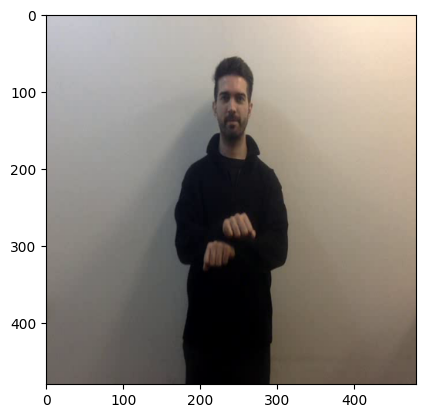

In [14]:
frame = X_aug[1][14]
# frame = X_aug[4][8]
# frame = X[15][4]
# frame = X_aug[35][4]
plt.imshow(frame)


In [15]:
results = detect_landmarks(frame)
x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)


✅ Right hand detected
✅ Left hand detected
✅ Pose detected


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


✅ Right hand annotated
✅ Left hand annotated
✅ Pose annotated


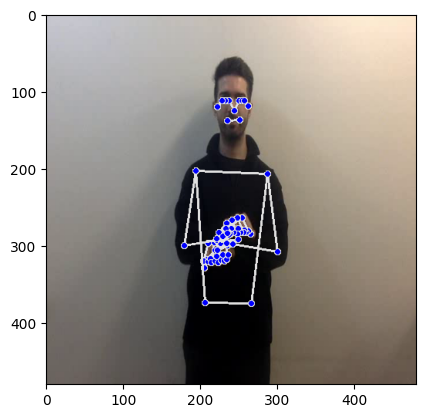

In [16]:
annotated_image = draw_(results, frame)
plt.imshow(annotated_image)


In [17]:
print(len(x_coord_R_hand))
print(len(y_coord_R_hand))
print(len(z_coord_R_hand))
print(len(x_coord_L_hand))
print(len(y_coord_L_hand))
print(len(z_coord_L_hand))
print(len(x_coord_pose))
print(len(y_coord_pose))
print(len(z_coord_pose))


21
21
21
21
21
21
25
25
25


In [18]:
X_frame = normalized_coordinates_per_frame(results)
len(X_frame)


✅ Right hand detected
✅ Left hand detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected


201

### 2.3 Get coordinates for all frames

In [19]:
def mediapipe_video_to_coord(X):
    X_coord = []

    for video_count in range(len(X)):
        video = X[video_count]
        video_frames = []

        for frame_count in range(num_frames):
            frame = video[frame_count]
            results = detect_landmarks(frame)
            # X_frame = coordinates_per_frame(results)
            X_frame = normalized_coordinates_per_frame(results)
            video_frames.append(X_frame)

        X_coord.append(video_frames)

    X_coord = tf.convert_to_tensor(X_coord)
    return X_coord


In [20]:
X_aug_coord = mediapipe_video_to_coord(X_aug)
X_aug_coord.shape


❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅

2023-11-27 15:59:49.835662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 15:59:49.835953: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/eigot/.pyenv/versions/3.10.6/envs/SignFlow/lib/python3.10/site-packages/cv2/../../lib64:
2023-11-27 15:59:49.836074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/eigot/.pyenv/versions/3.10.6/envs/SignFlow/lib/python3.10/site-packages/cv2/../../lib64:
2023-11-27 15:59:49.836140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] C

TensorShape([210, 20, 201])

In [21]:
X_val_coord = mediapipe_video_to_coord(X_val)
X_val_coord.shape


❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detect

TensorShape([90, 20, 201])

### 2.4 Annotate videos?

In [22]:
# word = "family"
# video_list = list(selected_df[selected_df["word"] == word]["video_id"])
# video_list


In [24]:
# def detect_landmarks_frame(frame):
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     with mp_holistic.Holistic(min_detection_confidence=0.2, min_tracking_confidence=0.2, static_image_mode=False) as holistic:
#         results = holistic.process(frame_rgb)
#     return results


In [24]:
for video in video_list:
    video_path = f"../data/videos/{video}.mp4"
    output_video_path = f"../data/videos_test/{video}_annotated.mp4"

    cap = cv2.VideoCapture(video_path)

    # Get video details
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(filename=output_video_path, fourcc=fourcc, fps=20, frameSize=(frame_width, frame_height))

    if not out.isOpened():
        print("Could not open output video file for writing.")

    while cap.isOpened():
        print("------")
        ret, frame = cap.read()
        if not ret:

            break

        # Process the frame for landmark detection
        results = detect_landmarks_frame(frame)

        # Draw landmarks on the frame
        annotated_image = draw_(results, frame)

        # Write the frame with annotations to the output video
        out.write(annotated_image)

        # cv2.imshow('Video', annotated_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [25]:
# for i in range(20):
#     video_path = f"../data/processed_videos2/processed_{i}.mp4"
#     output_video_path = f"../data/videos_test/processed2_{i}_annotated.mp4"

#     cap = cv2.VideoCapture(video_path)

#     # Get video details
#     frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps = int(cap.get(cv2.CAP_PROP_FPS))

#     # Define the codec and create VideoWriter object
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out = cv2.VideoWriter(filename=output_video_path, fourcc=fourcc, fps=5, frameSize=(frame_width, frame_height))

#     if not out.isOpened():
#         print("Could not open output video file for writing.")

#     while cap.isOpened():
#         print("------")
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Process the frame for landmark detection
#         results = detect_landmarks_frame(frame)

#         # Draw landmarks on the frame
#         annotated_image = draw_(results, frame)

#         # Write the frame with annotations to the output video
#         out.write(annotated_image)

#         # cv2.imshow('Video', annotated_image)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     out.release()
#     cv2.destroyAllWindows()


# 2 (TEST) train on hands only

### 2.1 Define functions

In [25]:
mp_hands = mp.solutions.hands

def detect_landmarks_hand(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    with mp_hands.Hands(min_detection_confidence=0.1, min_tracking_confidence=0.1, static_image_mode=False) as hands:
        results = hands.process(frame_rgb)
    return results


In [26]:
def get_coord_for_hands(results):
    x_coord_R_hand = []
    y_coord_R_hand = []
    z_coord_R_hand = []

    x_coord_L_hand = []
    y_coord_L_hand = []
    z_coord_L_hand = []

    if results.multi_hand_landmarks:
        # Loop over all detected hands
        for hand_landmarks in results.multi_hand_landmarks:
            # Check if the hand has landmarks
            if hand_landmarks:
                # Check if the detected hand is a right hand
                if len(hand_landmarks.landmark) == 21:  # Assuming 21 landmarks for each hand
                    for landmark in hand_landmarks.landmark:
                        if landmark:
                            if hand_landmarks == results.multi_hand_landmarks[0]:
                                x_coord_R_hand.append(landmark.x)
                                y_coord_R_hand.append(landmark.y)
                                z_coord_R_hand.append(landmark.z)
                            else:
                                x_coord_L_hand.append(landmark.x)
                                y_coord_L_hand.append(landmark.y)
                                z_coord_L_hand.append(landmark.z)
                    print("✅ Hand detected")

    else:
        # If no hands detected, populate with zeros
        for index in range(21):
            x_coord_R_hand.append(0)
            y_coord_R_hand.append(0)
            z_coord_R_hand.append(0)

            x_coord_L_hand.append(0)
            y_coord_L_hand.append(0)
            z_coord_L_hand.append(0)
        print("❌ No hands detected")

    # return x_coord_R_hand, y_coord_R_hand, z_coord_R_hand, x_coord_L_hand, y_coord_L_hand, z_coord_L_hand
    return x_coord_R_hand + y_coord_R_hand + z_coord_R_hand + x_coord_L_hand + y_coord_L_hand + z_coord_L_hand


In [27]:
import mediapipe as mp

def draw_hands(results, frame):
    mp_drawing = mp.solutions.drawing_utils
    annotated_image = frame.copy()

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image=annotated_image,
                landmark_list=hand_landmarks,
                connections=mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec=mp_drawing_styles.get_default_hand_connections_style())
        print("✅ Hands annotated")
    else:
        print("❌ Hands not annotated")

    return annotated_image


### 2.2 Try on one frame

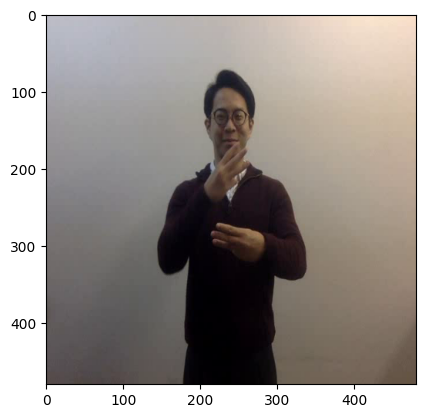

In [28]:
frame = X_aug[4][6]
# frame = X_aug[4][8]
# frame = X[15][4]
# frame = X_aug[35][4]
plt.imshow(frame)


In [29]:
results2 = detect_landmarks_hand(frame)
output = get_coord_for_hands(results2)
len(output)


❌ No hands detected


126

(0.0, 1.0)

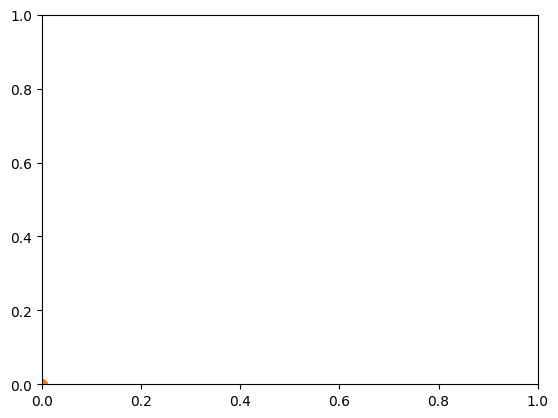

In [30]:
plt.scatter(output[0:21], output[21:42])
plt.scatter(output[63:84], output[84:105])
plt.ylim(0,1)
plt.xlim(0,1)


❌ Hands not annotated


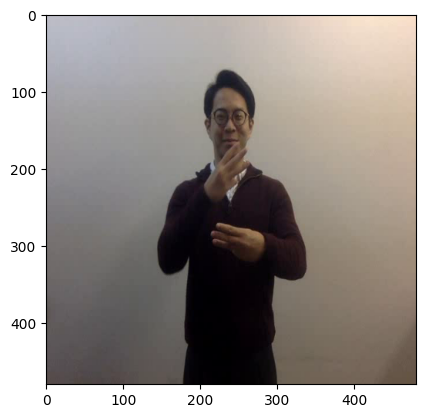

In [31]:
annotated_image = draw_hands(results2, frame)
plt.imshow(annotated_image)


### 2.3 Get coordinates for all frames

In [32]:
def mediapipe_video_to_coord_hand(X):
    X_coord = []

    for video_count in range(len(X)):
        video = X[video_count]
        video_frames = []

        for frame_count in range(num_frames):
            frame = video[frame_count]
            results = detect_landmarks_hand(frame)
            X_frame = get_coord_for_hands(results)
            video_frames.append(X_frame)

        X_coord.append(video_frames)

    X_coord = tf.convert_to_tensor(X_coord)
    return X_coord


In [35]:
# X_aug_coord = mediapipe_video_to_coord_hand(X_aug)
# X_aug_coord.shape

# X_val_coord = mediapipe_video_to_coord_hand(X_val[0:1])
# X_val_coord.shape


### 2.4 Annotate videos

# 3. Prepare X_train, X_val, y_train, y_val

In [23]:
X_train = X_aug_coord
X_val = X_val_coord
y_train = y_aug
y_val = y_cat_val

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(210, 20, 201)
(90, 20, 201)
(210, 15)
(90, 15)


# 4. Train and evaluate model (using simple RNN)

In [24]:
# dim = 168
dim = 201


In [25]:
def model_initialize_simple(dim):
    model = Sequential()
    model.add(layers.Masking(input_shape=(num_frames, dim), mask_value=0))
    model.add(layers.LSTM(units=512, activation="tanh", return_sequences=True))
    model.add(layers.LSTM(units=256, activation="tanh"))
    model.add(layers.Dense(num_classes, activation="softmax"))
    return model

model = model_initialize_simple(dim)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 20, 201)           0         
                                                                 
 lstm (LSTM)                 (None, 20, 512)           1462272   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 15)                3855      
                                                                 
Total params: 2,253,583
Trainable params: 2,253,583
Non-trainable params: 0
_________________________________________________________________


In [26]:
learning_rate = 1e-4

def model_compile(model):
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"]
    )
    return model

model = model_compile(model)


In [27]:
es = EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[es]
)


Epoch 1/300
14/14 [==============================] - 10s 166ms/step - loss: 2.5858 - accuracy: 0.2048 - val_loss: 2.2714 - val_accuracy: 0.4444
Epoch 2/300
14/14 [==============================] - 1s 68ms/step - loss: 2.1124 - accuracy: 0.4095 - val_loss: 1.9172 - val_accuracy: 0.4111
Epoch 3/300
14/14 [==============================] - 1s 60ms/step - loss: 1.7076 - accuracy: 0.4810 - val_loss: 1.5971 - val_accuracy: 0.5111
Epoch 4/300
14/14 [==============================] - 1s 72ms/step - loss: 1.3508 - accuracy: 0.5905 - val_loss: 1.3375 - val_accuracy: 0.5333
Epoch 5/300
14/14 [==============================] - 1s 62ms/step - loss: 1.1061 - accuracy: 0.6143 - val_loss: 1.1794 - val_accuracy: 0.5778
Epoch 6/300
14/14 [==============================] - 1s 57ms/step - loss: 0.9650 - accuracy: 0.6429 - val_loss: 1.0645 - val_accuracy: 0.6111
Epoch 7/300
14/14 [==============================] - 1s 72ms/step - loss: 0.8432 - accuracy: 0.6714 - val_loss: 0.9878 - val_accuracy: 0.6000
Epoc

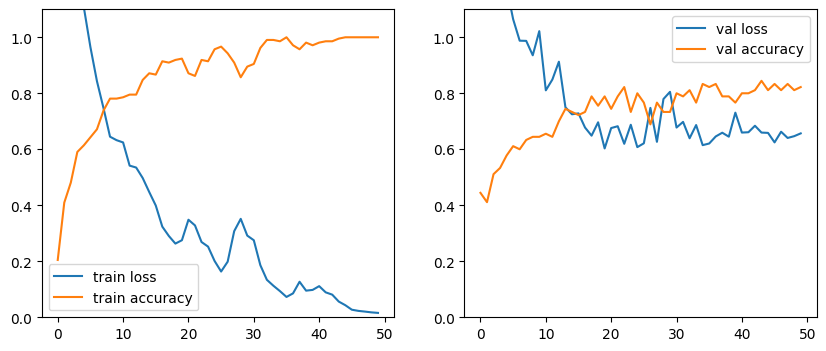

In [28]:
def plot_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

    ax1.plot(history.__dict__["history"]["loss"], label="train loss")
    ax1.plot(history.__dict__["history"]["accuracy"], label="train accuracy")
    ax1.legend()
    ax1.set_ylim(0,1.1)

    ax2.plot(history.__dict__["history"]["val_loss"], label="val loss")
    ax2.plot(history.__dict__["history"]["val_accuracy"], label="val accuracy")
    ax2.legend()
    ax2.set_ylim(0,1.1)

plot_accuracy(history)


In [31]:
from backend.ml_logic.registry import save_model
save_model(model)


/home/eigot/code/Kaaykun/SignFlow/backend/../models/20231127-161013.h5 updated function 2
20231127-161013.h5
✅ Model saved locally


: 

# 5. Evaluate

In [29]:
label_to_number


{'bye': 2,
 'love': 6,
 'many': 7,
 'world': 12,
 'thankyou': 9,
 'work': 11,
 'hello': 5,
 'go': 4,
 'yes': 13,
 'you': 14,
 'beer': 1,
 'I': 0,
 'drink': 3,
 'what': 10,
 'no': 8}

In [30]:
from sklearn.metrics import precision_score, accuracy_score

y_pred = model.predict(X_val)
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_val, axis=1)

class_accuracy = {}

for i in range(num_classes):
    #get the word for index i
    for key, value in label_to_number.items():
        if value == i:
            desired_key = key
            break

    #calculate precision and accuracy and save
    idx = true_classes == i
    class_accuracy[desired_key] = accuracy_score(true_classes[idx], predicted_classes[idx])


#print
for class_name, acc in class_accuracy.items():
    print(f"{class_name}: {acc:.4f}")


3/3 [==============================] - 1s 32ms/step
I: 0.5000
beer: 0.8333
bye: 0.8333
drink: 1.0000
go: 0.6667
hello: 1.0000
love: 1.0000
many: 0.8333
no: 0.6667
thankyou: 0.8333
what: 1.0000
work: 1.0000
world: 0.8333
yes: 0.1667
you: 0.6667
